# Introduction

This draft is to setup a bench of scenarios for visualizing DP aggregated results. We test our interface using three libraries, _Whitenoise-core_, _Whitenoise-system_, and _Google C++_. And our goal is to cover as much scenarios as possible and finally decide what kinds of plots are most appropriate for different scenarios.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
from scipy import stats
from scipy.stats import entropy
from numpy.linalg import norm
import matplotlib.pyplot as plt
import opendp.whitenoise.core as wn
from opendp.whitenoise.sql import PandasReader, PrivateReader, execute_private_query, SqlServerReader
from opendp.whitenoise.metadata import CollectionMetadata
from opendp.whitenoise.metadata.collection import *
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.offline import plot
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
from datetime import datetime


To start with, we can load a dummy dataset, "PUMS", as our testing dataset.

In [2]:
# establish data information

data_path = "/mnt/c/Users/mqdmj/Documents/GitHub/whitenoise-system/service/datasets/PUMS.csv"
metadata_path = "/mnt/c/Users/mqdmj/Documents/GitHub/whitenoise-system/service/datasets/PUMS.yaml"
var_names = ["age", "sex", "educ", "race", "income", "married", "pid"]

In this notebook we are focusing mainly on testing `MEAN`.

`MEAN` is an aggregation algorithm implemented on numerical variables, so we select _income_ as our testing variable.

Let's overview some descriptive statistics of this variable.

Mean of Income:  34380.084


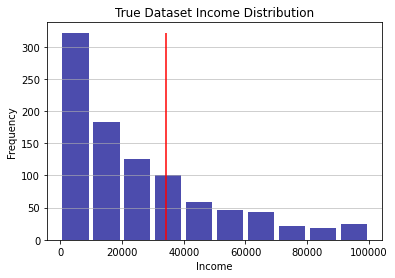

In [3]:
data = np.genfromtxt(data_path, delimiter=',', names=True)

income = list(data[:]['income'])
print("Mean of Income: ", np.mean(income))

# An "interface" to matplotlib.axes.Axes.hist() method
n_income, bins, patches = plt.hist(income, bins=list(range(0,110000,10000)), color='darkblue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('True Dataset Income Distribution')
plt.vlines(x=np.mean(income), ymin = 0, ymax = np.max(n_income), colors='red')
plt.show()

Now we want to test different DP libraries with _income_. Let's start with building DP MEAN functions for these libraries. We should first refer to the C++ code "GoogleDP.cc" to generate datasets with different sizes and their neighboring datasets. This file will also output the DP results for _Google C++_ library.


For _WhiteNoise-Core_ and _WhiteNoise-System_, we manually clamp the DP results in an given interval $[0, 500000]$, which in real cases will be an experienced interval provided by data holders.


In [4]:
## 1. WhiteNoise-Core

# set ranges/feasible values
income_range = (0., 500_000.)

# Create dp_mean function for WhiteNoise-Core
def dp_mean_wn(eps, dp, delta = 10E-16):
    
    temp = pd.read_csv(dp, header = None)
    
    income = temp[0].to_list()

    with wn.Analysis() as analysis:

        # load data
        data = wn.Dataset(path = dp, column_names = ['income'], skip_row = False)

        # establish data 
        income_dt = wn.to_float(data['income'])
        
        # clamp data to range
        income_dt = wn.clamp(data = income_dt, lower = income_range[0], upper = income_range[1])

        # impute data to avoid nullity
        income_dt = wn.impute(data = income_dt, lower = income_range[0], upper = income_range[1])
        
        # ensure data are consistent with proposed size
        income_dt = wn.resize(data = income_dt, n = len(income))
        
        # calculate differentially private mean of income
        result = wn.dp_mean(data = income_dt, privacy_usage={'epsilon': eps, 'delta': delta})
          
    analysis.release()

    result_value = result.value

    if result_value < 0:
        result_value = 0
    elif result_value > 500000:
        result_value = 500000

    return result_value



# Create dp_sum function for WhiteNoise-Core
def dp_sum_wn(eps, dp, delta = 10E-16):
    
    temp = pd.read_csv(dp, header = None)
    
    income = temp[0].to_list()

    with wn.Analysis() as analysis:

        # load data
        data = wn.Dataset(path = dp, column_names = ['income'], skip_row = False)

        # establish data 
        income_dt = wn.to_float(data['income'])
        
        # clamp data to range
        income_dt = wn.clamp(data = income_dt, lower = income_range[0], upper = income_range[1])

        # impute data to avoid nullity
        income_dt = wn.impute(data = income_dt, lower = income_range[0], upper = income_range[1])
        
        # ensure data are consistent with proposed size
        income_dt = wn.resize(data = income_dt, n = len(income))
        
        # calculate differentially private mean of income
        result = wn.dp_sum(data = income_dt, privacy_usage={'epsilon': eps, 'delta': delta})
          
    analysis.release()

    result_value = result.value

    if result_value < 0:
        result_value = 0
    elif result_value > 500000*len(income):
        result_value = 500000*len(income)

    return result_value


# Create dp_count function for WhiteNoise-Core
def dp_count_wn(eps, dp, delta = 10E-16):
    
    temp = pd.read_csv(dp, header = None)
    
    income = temp[0].to_list()

    with wn.Analysis() as analysis:

        # load data
        data = wn.Dataset(path = dp, column_names = ['income'], skip_row = False)

        # establish data 
        income_dt = wn.to_string(data['income'])
        
        # calculate differentially private mean of income
        result = wn.dp_count(data = income_dt, mechanism="Laplace", privacy_usage={'epsilon': eps, 'delta': delta})
          
    analysis.release()

    result_value = int(round(result.value))

    return result_value



## 2. WhiteNoise-System

metatable = Table("PUMS", "PUMS", len(income), \
            [\
                Int("income", 0, 500000)
            ])

def dp_mean_ws(eps, dp, delta = 10E-16):

    # load data
    temp = pd.read_csv(dp, header = None)
    data = temp.rename(columns = {0 : "income"})

    schema = metatable

    schema.rowcount = data.shape[0]

    meta = CollectionMetadata([schema], "csv")
    
    query = 'SELECT AVG(income) AS income FROM PUMS.PUMS'
    
    reader = PandasReader(meta, data)
    
    rowset = execute_private_query(meta, reader, eps, query)
    #rowset = PrivateReader(meta, reader, epsilon_per_column = eps).execute(query)

    df = pd.DataFrame(rowset[1:], columns=rowset[0])

    result = df['income'][0]

    if result < 0:
        result = 0
    elif result > 500000:
        result = 500000

    return result


def dp_sum_ws(eps, dp, delta = 10E-16):

    # load data
    temp = pd.read_csv(dp, header = None)
    data = temp.rename(columns = {0 : "income"})

    schema = metatable

    schema.rowcount = data.shape[0]

    meta = CollectionMetadata([schema], "csv")
    
    query = 'SELECT SUM(income) AS income FROM PUMS.PUMS'
    
    reader = PandasReader(meta, data)
    
    rowset = execute_private_query(meta, reader, eps, query)
    #rowset = PrivateReader(meta, reader, epsilon_per_column = eps).execute(query)

    df = pd.DataFrame(rowset[1:], columns=rowset[0])

    result = df['income'][0]

    if result < 0:
        result = 0
    elif result > 500000*data.shape[0]:
        result = 500000*data.shape[0]

    return result


def dp_count_ws(eps, dp, delta = 10E-16):

    # load data
    temp = pd.read_csv(dp, header = None)
    data = temp.rename(columns = {0 : "income"})

    schema = metatable

    schema.rowcount = data.shape[0]

    meta = CollectionMetadata([schema], "csv")
    
    query = 'SELECT COUNT(income) AS income FROM PUMS.PUMS'
    
    reader = PandasReader(meta, data)
    
    rowset = execute_private_query(meta, reader, eps, query)
    #rowset = PrivateReader(meta, reader, epsilon_per_column = eps).execute(query)

    df = pd.DataFrame(rowset[1:], columns=rowset[0])

    result = df['income'][0]

    return result
    

## 3. Google's library (C++)
## Refer to relative C++ file 


Then we set a global parameter, iteration, let it be 500.

In [7]:
# set iterations for all three libraries

iters = 500

Then we can test under different metrics across with different privacy parameters.


# Plots

## MSE

### MSE vs $\epsilon$

We set up $\epsilon$ ranging from $0.1$ to $5.1$ increasing by $1.0$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. Dataset size here we use is 1000, which is the number of all records.


In [6]:
# set epsilon values

epsilon = [round(0.1 * i, 1) for i in range(1, 52, 10)]

In [7]:
## 1. WhiteNoise-Core

income_mse_eps_wn = []
for eps in epsilon:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        income_mean_each.append(element)
    income_mse_eps_wn.append(np.mean((income_mean_each - np.mean(income))**2))

df_wn = pd.DataFrame({"epsilon": epsilon, "mse_wn": income_mse_eps_wn})
print("WhiteNoise-Core MSE vs Epsilon: \n", df_wn)

WhiteNoise-Core MSE vs Epsilon: 
    epsilon        mse_wn
0      0.1  5.555427e+07
1      1.1  3.663189e+05
2      2.1  1.244934e+05
3      3.1  5.188342e+04
4      4.1  3.201015e+04
5      5.1  1.974195e+04


In [8]:
## 2. WhiteNoise-System

income_mse_eps_ws = []
for eps in epsilon:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        income_mean_each.append(element)
    income_mse_eps_ws.append(np.mean((income_mean_each - np.mean(income))**2))

df_ws = pd.DataFrame({"epsilon": epsilon, "mse_ws": income_mse_eps_ws})
print("WhiteNoise-System MSE vs Epsilon: \n", df_ws)

WhiteNoise-System MSE vs Epsilon: 
    epsilon        mse_ws
0      0.1  1.331227e+09
1      1.1  1.261478e+07
2      2.1  3.898880e+06
3      3.1  1.858181e+06
4      4.1  9.486327e+05
5      5.1  8.123073e+05


In [9]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
income_mse_eps_go = []
idx_eps = 0
for eps in epsilon:
    income_mean_each = list(google_result[:][idx_eps*3 + 2])
    income_mse_eps_go.append(np.mean((income_mean_each - np.mean(income))**2))
    idx_eps = idx_eps + 1

df_go = pd.DataFrame({"epsilon": epsilon, "mse_go": income_mse_eps_go})
print("Google C++ MSE vs Epsilon: \n", df_go)

Google C++ MSE vs Epsilon: 
    epsilon        mse_go
0      0.1  9.186117e+07
1      1.1  9.134913e+05
2      2.1  2.089613e+05
3      3.1  1.026869e+05
4      4.1  5.359218e+04
5      5.1  3.258544e+04


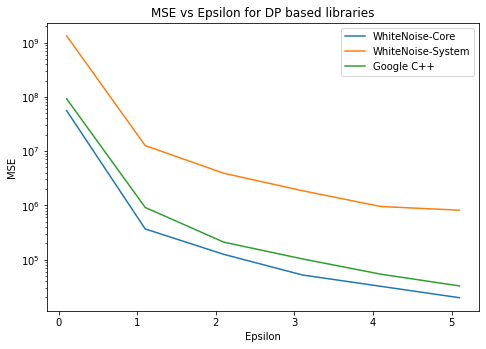

In [10]:
## Plotting for MSE vs epsilon

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(epsilon, income_mse_eps_wn, label = "WhiteNoise-Core")
ax.plot(epsilon, income_mse_eps_ws, label = "WhiteNoise-System")
ax.plot(epsilon, income_mse_eps_go, label = "Google C++")
ax.legend()
plt.yscale('log')
plt.xlabel('Epsilon')
plt.ylabel('MSE')
plt.title('MSE vs Epsilon for DP based libraries')
plt.show()

We can see all libraries display decreasing patterns while the MSE curve of _WhiteNoise-System_ is always higher than the other two.


### MSE vs Dataset size


We set up dataset size ranging from $10$ to $1000$ increasing by power of $10$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. $\epsilon$ here we use is $1.0$.


In [7]:
# set dataset size values

dataset_size = [10 ** i for i in range(1, 4)]

In [13]:
## 1. WhiteNoise-Core

income_mse_n_wn = []
for n in dataset_size:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_wn(1.0, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        income_mean_each.append(element)
    income_mse_n_wn.append(np.mean((income_mean_each - np.mean(income))**2))

df_wn = pd.DataFrame({"n": dataset_size, "mse_wn": income_mse_n_wn})
print("WhiteNoise-Core MSE vs Dataset size: \n", df_wn)

WhiteNoise-Core MSE vs Dataset size: 
       n        mse_wn
0    10  8.328799e+09
1   100  9.187113e+07
2  1000  4.598068e+05


In [14]:
## 2. WhiteNoise-System

income_mse_n_ws = []
for n in dataset_size:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_ws(1.0, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        income_mean_each.append(element)
    income_mse_n_ws.append(np.mean((income_mean_each - np.mean(income))**2))

df_ws = pd.DataFrame({"n": dataset_size, "mse_ws": income_mse_n_ws})
print("WhiteNoise-System MSE vs Dataset siez: \n", df_ws)

WhiteNoise-System MSE vs Dataset siez: 
       n        mse_ws
0    10  6.727996e+10
1   100  1.112333e+09
2  1000  1.785985e+07


In [15]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
income_mse_n_go = []
idx_n = 0
for n in dataset_size:
    income_mean_each = list(google_result[:][3 + idx_n])
    income_mse_n_go.append(np.mean((income_mean_each - np.mean(income))**2))
    idx_n = idx_n + 1

df_go = pd.DataFrame({"n": dataset_size, "mse_go": income_mse_n_go})
print("Google C++ MSE vs Dataset size: \n", df_go)

Google C++ MSE vs Dataset size: 
       n        mse_go
0    10  7.971273e+09
1   100  1.305227e+08
2  1000  9.134913e+05


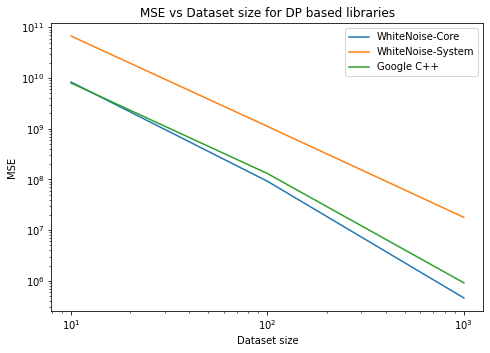

In [16]:
## Plotting for MSE vs epsilon

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataset_size, income_mse_n_wn, label = "WhiteNoise-Core")
ax.plot(dataset_size, income_mse_n_ws, label = "WhiteNoise-System")
ax.plot(dataset_size, income_mse_n_go, label = "Google C++")
ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset size')
plt.ylabel('MSE')
plt.title('MSE vs Dataset size for DP based libraries')
plt.show()

We can see all libraries display decreasing patterns while the MSE curve of _WhiteNoise-System_ is always higher than the other two. 

Note: For small dataset size, $n=10$, `inf` or `-inf` was gotten from _WhiteNoise-System_.


## Bias

### Bias vs Epsilon

We set up $\epsilon$ ranging from $0.1$ to $5.1$ increasing by $1.0$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. Dataset size here we use is 1000, which is the number of all records.


In [17]:
## 1. WhiteNoise-Core

income_mean_eps_wn = []
for eps in epsilon:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        income_mean_each.append(element)
    income_mean_eps_wn.append(income_mean_each)

In [18]:
## 2. WhiteNoise-System

income_mean_eps_ws = []
for eps in epsilon:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        income_mean_each.append(element)
    income_mean_eps_ws.append(income_mean_each)

In [19]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
income_mean_eps_go = []
idx_eps = 0
for eps in epsilon:
    income_mean_each = list(google_result[:][idx_eps*3 + 2])
    income_mean_eps_go.append(income_mean_each)
    idx_eps = idx_eps + 1

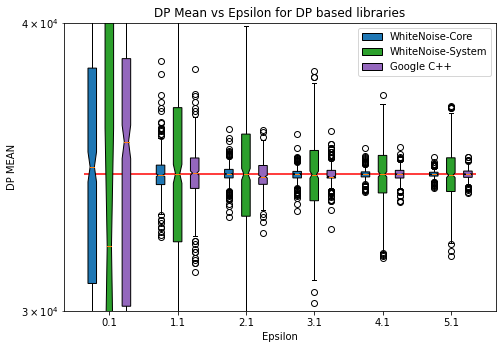

In [20]:
## Plotting for Bias vs Epsilon

labels = list(map(str, epsilon))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp_wn = ax.boxplot(income_mean_eps_wn, positions = range(1, 22, 4), notch = True, widths = 0.5, patch_artist = True, boxprops=dict(facecolor="C0"), manage_ticks = False)
bp_ws = ax.boxplot(income_mean_eps_ws, positions = range(2, 23, 4), notch = True, widths = 0.5, patch_artist = True, labels = epsilon, boxprops=dict(facecolor="C2"))
bp_go = ax.boxplot(income_mean_eps_go, positions = range(3, 24, 4), notch = True, widths = 0.5, patch_artist = True, boxprops=dict(facecolor="C4"), manage_ticks = False)
ax.legend([bp_wn["boxes"][0], bp_ws["boxes"][0], bp_go["boxes"][0]], ['WhiteNoise-Core', 'WhiteNoise-System', "Google C++"], loc='upper right')
plt.yscale('log')
plt.xlabel('Epsilon')
plt.ylim(3*10**4, 4*10**4)
plt.hlines(y = np.mean(income), xmin = 0.5, xmax = 23.5, color = 'red')
plt.ylabel('DP MEAN')
plt.title('DP Mean vs Epsilon for DP based libraries')
plt.show()

We can see when epsilon increases, the variation of DP MEAN for all packages decreases. And the bias goes down for all packages. Note that _WhiteNoise-Core_ and _Google C++_ have more stable performance than _WhiteNoise-System_.


### Bias vs Dataset size

We set up dataset size ranging from $10$ to $1000$ increasing by power of $10$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. $\epsilon$ here we use is $1.0$.

In [21]:
## 1. WhiteNoise-Core

income_mean_n_wn = []
for n in dataset_size:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_wn(1.0, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        income_mean_each.append(element)
    income_mean_n_wn.append(income_mean_each)

In [22]:
## 2. WhiteNoise-System

income_mean_n_ws = []
for n in dataset_size:
    income_mean_each = []
    for i in range(iters):
        element = dp_mean_ws(1.0, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        income_mean_each.append(element)
    income_mean_n_ws.append(income_mean_each)

In [23]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
income_mean_n_go = []
idx_n = 0
for n in dataset_size:
    income_mean_each = list(google_result[:][3 + idx_n])
    income_mean_n_go.append(income_mean_each)
    idx_n = idx_n + 1

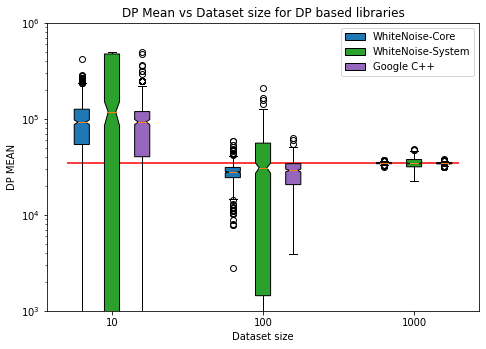

In [24]:
## Plotting for Bias vs Dataset size

labels = list(map(str, dataset_size))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp_wn = ax.boxplot(income_mean_n_wn, positions = range(1, 12, 5), notch = True, widths = 0.5, patch_artist = True, boxprops=dict(facecolor="C0"), manage_ticks = False)
bp_ws = ax.boxplot(income_mean_n_ws, positions = range(2, 13, 5), notch = True, widths = 0.5, patch_artist = True, labels = dataset_size, boxprops=dict(facecolor="C2"))
bp_go = ax.boxplot(income_mean_n_go, positions = range(3, 14, 5), notch = True, widths = 0.5, patch_artist = True, boxprops=dict(facecolor="C4"), manage_ticks = False)
ax.legend([bp_wn["boxes"][0], bp_ws["boxes"][0], bp_go["boxes"][0]], ['WhiteNoise-Core', 'WhiteNoise-System', "Google C++"], loc='upper right')
plt.yscale('log')
plt.xlabel('Dataset size')
plt.ylim(10**3, 10**6)
plt.hlines(y = np.mean(income), xmin = 0.5, xmax = 13.5, color = 'red')
plt.ylabel('DP MEAN')
plt.title('DP Mean vs Dataset size for DP based libraries')
plt.show()

We can see when dataset size increases, the variation of DP MEAN for all packages decreases. And the bias goes down for all packages. Note that _WhiteNoise-Core_ and _Google C++_ have more stable performance than _WhiteNoise-System_, especially for small dataset sizes.

## Jenson-Shannon Divergence

### JS Divergence vs Epsilon

We set up $\epsilon$ ranging from $0.1$ to $5.1$ increasing by $1.0$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. Dataset size here we use is 1000, which is the number of all records.



We first create a function to calculate Jenson-Shannon Divergence as below.


In [8]:
# calculate the Jenson-Shannon Divergence
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

Then we build a function to get histogram statistics of neighboring datasets for calculating JS divergence using _Freedman-Diaconis Rule_. 


In [9]:
# Histogram for neighboring datasets
def generate_histogram_neighbors(fD1, fD2, numbins=0, binsize="auto", exact=False):
    d1 = fD1
    d2 = fD2
    d = np.concatenate((d1, d2), axis=None)
    n = d.size
    binlist = []
    minval = min(min(d1), min(d2))
    maxval = max(max(d1), max(d2))
    if(exact):
        binlist = np.linspace(minval, maxval, 2)
    elif(numbins > 0):
        binlist = np.linspace(minval, maxval, numbins)
    elif(binsize == "auto"):
        iqr = np.subtract(*np.percentile(d, [75, 25]))
        numerator = 2 * iqr if iqr > 0 else maxval - minval
        denominator = n ** (1. / 3)
        binwidth = numerator / denominator # Freedman–Diaconis' choice
        numbins = int(math.ceil((maxval - minval) / binwidth)) if maxval > minval else 20
        binlist = np.linspace(minval, maxval, numbins)
    else:
        # Choose bin size of unity
        binlist = np.arange(np.floor(minval),np.ceil(maxval))

    # Calculating histograms of fD1 and fD2
    d1hist, bin_edges = np.histogram(d1, bins = binlist, density = False)
    d2hist, bin_edges = np.histogram(d2, bins = binlist, density = False)

    return d1hist, d2hist, bin_edges, binlist


Since histogram binwidth is an arbitrary selection, in some cases certain bins will contain no counts for both histograms especially for small iterations, we will exclude these bins when calculating JS divergence. And actually these empty bins stands for zero-probabily, which will not affect the result of JS divergence. 


In [27]:
## 1. WhiteNoise-Core

income_js_eps_wn = []

for eps in epsilon:
    d1_wn = []
    d2_wn = []
    for i in range(iters):
        element1 = dp_mean_wn(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        element2 = dp_mean_wn(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n999.csv")
        d1_wn.append(element1)
        d2_wn.append(element2)
    temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
    c1_wn = temp_hist[0]
    c2_wn = temp_hist[1]
    p1_wn_temp = c1_wn / np.sum(c1_wn)
    p2_wn_temp = c2_wn / np.sum(c2_wn)
    p1_wn = [p1_wn_temp[i] for i in range(len(p1_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
    p2_wn = [p2_wn_temp[i] for i in range(len(p2_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
    income_js_eps_wn.append(JSD(p1_wn, p2_wn))

js_wn = pd.DataFrame({"epsilon": epsilon, "JS_wn": income_js_eps_wn})
print("WhiteNoise-Core Jenson-Shannon Divergence vs Epsilon: \n", js_wn)


WhiteNoise-Core Jenson-Shannon Divergence vs Epsilon: 
    epsilon     JS_wn
0      0.1  0.016742
1      1.1  0.022943
2      2.1  0.016032
3      3.1  0.032829
4      4.1  0.043497
5      5.1  0.032399


In [28]:
## 2. WhiteNoise-System

income_js_eps_ws = []
for eps in epsilon:
    d1_ws = []
    d2_ws = []
    for i in range(iters):
        element1 = dp_mean_ws(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        element2 = dp_mean_ws(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n999.csv")
        d1_ws.append(element1)
        d2_ws.append(element2)
    temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
    c1_ws = temp_hist[0]
    c2_ws = temp_hist[1]
    p1_ws_temp = c1_ws / np.sum(c1_ws)
    p2_ws_temp = c2_ws / np.sum(c2_ws)
    p1_ws = [p1_ws_temp[i] for i in range(len(p1_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
    p2_ws = [p2_ws_temp[i] for i in range(len(p2_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
    income_js_eps_ws.append(JSD(p1_ws, p2_ws))

js_ws = pd.DataFrame({"epsilon": epsilon, "JS_ws": income_js_eps_ws})
print("WhiteNoise-System Jenson-Shannon Divergence vs Epsilon: \n", js_ws)


WhiteNoise-System Jenson-Shannon Divergence vs Epsilon: 
    epsilon     JS_ws
0      0.1  0.008495
1      1.1  0.015412
2      2.1  0.014080
3      3.1  0.011867
4      4.1  0.013029
5      5.1  0.011152


In [29]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)
income_js_eps_go = []
idx_eps = 0
for eps in epsilon:
    d1_go = list(google_result[:][idx_eps*3+2])
    d2_go = list(google_result2[:][idx_eps*3+2])
    temp_hist = generate_histogram_neighbors(d1_go, d2_go)
    c1_go = temp_hist[0]
    c2_go = temp_hist[1]
    p1_go_temp = c1_go / np.sum(c1_go)
    p2_go_temp = c2_go / np.sum(c2_go)
    p1_go = [p1_go_temp[i] for i in range(len(p1_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
    p2_go = [p2_go_temp[i] for i in range(len(p2_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
    income_js_eps_go.append(JSD(p1_go, p2_go))
    idx_eps = idx_eps + 1

js_go = pd.DataFrame({"epsilon": epsilon, "JS_ws": income_js_eps_go})
print("Google C++ Jenson-Shannon Divergence vs Epsilon: \n", js_go)




Google C++ Jenson-Shannon Divergence vs Epsilon: 
    epsilon     JS_ws
0      0.1  0.014371
1      1.1  0.033175
2      2.1  0.046016
3      3.1  0.258544
4      4.1  0.210330
5      5.1  0.334683


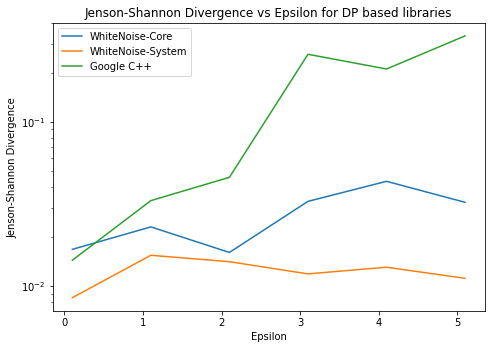

In [30]:
## Plotting for Jenson-Shannon Divergence vs Epsilon

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(epsilon, income_js_eps_wn, label = "WhiteNoise-Core")
ax.plot(epsilon, income_js_eps_ws, label = "WhiteNoise-System")
ax.plot(epsilon, income_js_eps_go, label = "Google C++")
ax.legend()
plt.yscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Jenson-Shannon Divergence')
plt.title('Jenson-Shannon Divergence vs Epsilon for DP based libraries')
plt.show()


We can see _Google C++_ shows an increasing pattern which indicates higher epsilon results in lower privacy. No obvious pattern shows for either _WhiteNoise-Core_ or _WhiteNoise-System_. Also _Google C++_ gives us highest JS divergence, then _WhiteNoise-Core_, then _WhiteNoise-System_.


### JS Divergence vs Dataset size

We set up dataset size ranging from $10$ to $1000$ increasing by power of $10$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. $\epsilon$ here we use is $1.0$.


In [31]:
## 1. WhiteNoise-Core

income_js_n_wn = []

for n in dataset_size:
    d1_wn = []
    d2_wn = []
    for i in range(iters):
        element1 = dp_mean_wn(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        element2 = dp_mean_wn(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
        d1_wn.append(element1)
        d2_wn.append(element2)
    temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
    c1_wn = temp_hist[0]
    c2_wn = temp_hist[1]
    p1_wn_temp = c1_wn / np.sum(c1_wn)
    p2_wn_temp = c2_wn / np.sum(c2_wn)
    p1_wn = [p1_wn_temp[i] for i in range(len(p1_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
    p2_wn = [p2_wn_temp[i] for i in range(len(p2_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
    income_js_n_wn.append(JSD(p1_wn, p2_wn))

js_wn = pd.DataFrame({"n": dataset_size, "JS_wn": income_js_n_wn})
print("WhiteNoise-Core Jenson-Shannon Divergence vs Dataset size: \n", js_wn)

WhiteNoise-Core Jenson-Shannon Divergence vs Dataset size: 
       n     JS_wn
0    10  0.032866
1   100  0.032141
2  1000  0.031265


In [32]:
## 2. WhiteNoise-System

income_js_n_ws = []

for n in dataset_size:
    d1_ws = []
    d2_ws = []
    for i in range(iters):
        element1 = dp_mean_ws(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        element2 = dp_mean_ws(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
        d1_ws.append(element1)
        d2_ws.append(element2)
    temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
    c1_ws = temp_hist[0]
    c2_ws = temp_hist[1]
    p1_ws_temp = c1_ws / np.sum(c1_ws)
    p2_ws_temp = c2_ws / np.sum(c2_ws)
    p1_ws = [p1_ws_temp[i] for i in range(len(p1_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
    p2_ws = [p2_ws_temp[i] for i in range(len(p2_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
    income_js_n_ws.append(JSD(p1_ws, p2_ws))

js_ws = pd.DataFrame({"n": dataset_size, "JS_wn": income_js_n_ws})
print("WhiteNoise-System Jenson-Shannon Divergence vs Dataset size: \n", js_ws)

WhiteNoise-System Jenson-Shannon Divergence vs Dataset size: 
       n     JS_wn
0    10  0.001736
1   100  0.013451
2  1000  0.010620


In [33]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)
income_js_n_go = []
idx_n = 0
for n in dataset_size:
    d1_go = list(google_result[:][3 + idx_n])
    d2_go = list(google_result2[:][3 + idx_n])
    temp_hist = generate_histogram_neighbors(d1_go, d2_go)
    c1_go = temp_hist[0]
    c2_go = temp_hist[1]
    p1_go_temp = c1_go / np.sum(c1_go)
    p2_go_temp = c2_go / np.sum(c2_go)
    p1_go = [p1_go_temp[i] for i in range(len(p1_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
    p2_go = [p2_go_temp[i] for i in range(len(p2_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
    income_js_n_go.append(JSD(p1_go, p2_go))
    idx_n = idx_n + 1

js_go = pd.DataFrame({"n": dataset_size, "JS_ws": income_js_n_go})
print("Google C++ Jenson-Shannon Divergence vs Dataset size: \n", js_go)

Google C++ Jenson-Shannon Divergence vs Dataset size: 
       n     JS_ws
0    10  0.034940
1   100  0.029819
2  1000  0.033175


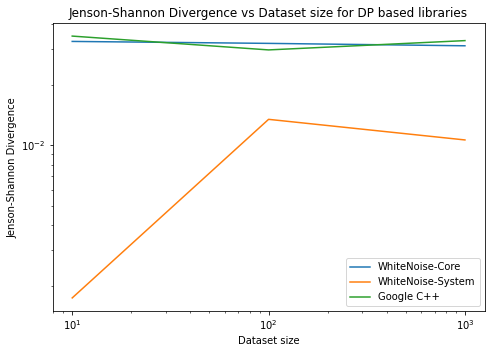

In [34]:
## Plotting for Jenson-Shannon Divergence vs Dataset size

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(dataset_size, income_js_n_wn, label = "WhiteNoise-Core")
ax.plot(dataset_size, income_js_n_ws, label = "WhiteNoise-System")
ax.plot(dataset_size, income_js_n_go, label = "Google C++")
ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset size')
plt.ylabel('Jenson-Shannon Divergence')
plt.title('Jenson-Shannon Divergence vs Dataset size for DP based libraries')
plt.show()

We can see _WhiteNoise-System_ show an increasing pattern which indicates larger dataset size results in lower privacy. No obvious pattern shows for _WhiteNoise-Core_ and _Google C++_. Also _Google C++_ gives us highest JS divergence, then _WhiteNoise-Core_, then _WhiteNoise-System_.


## DP Testing


We first create functions to plot bounded histograms.

In [35]:
# Bounded histogram values
def get_bounded_histogram(d1hist, d2hist, binlist, d1size, d2size, epsilon, delta = 10E-16, exact=False, alpha=0.05):
    """
    Check if histogram of fD1 values multiplied by e^epsilon and 
    summed by delta is bounding fD2 and vice versa
    Use the histogram results and create bounded histograms 
    to compare in DP test
    """
    d1_error_interval = 0.0
    d2_error_interval = 0.0
    # Lower and Upper bound
    if(not exact):
        num_buckets = binlist.size - 1
        critical_value = stats.norm.ppf(1-(alpha / 2 / num_buckets), loc=0.0, scale=1.0)
        d1_error_interval = critical_value * math.sqrt(num_buckets / d1size) / 2
        d2_error_interval = critical_value * math.sqrt(num_buckets / d2size) / 2

    num_buckets = binlist.size - 1
    px = np.divide(d1hist, d1size)
    py = np.divide(d2hist, d2size)

    d1histbound = px * math.exp(epsilon) + delta
    d2histbound = py * math.exp(epsilon) + delta

    d1upper = np.power(np.sqrt(px * num_buckets) + d1_error_interval, 2) / num_buckets
    d2upper = np.power(np.sqrt(py * num_buckets) + d2_error_interval, 2) / num_buckets
    d1lower = np.power(np.sqrt(px * num_buckets) - d1_error_interval, 2) / num_buckets
    d2lower = np.power(np.sqrt(py * num_buckets) - d2_error_interval, 2) / num_buckets

    np.maximum(d1lower, 0.0, d1lower)
    np.maximum(d2lower, 0.0, d1lower)

    d1histupperbound = d1upper * math.exp(epsilon) + delta
    d2histupperbound = d2upper * math.exp(epsilon) + delta

    return px, py, d1histupperbound, d2histupperbound, d1histbound, d2histbound, d1lower, d2lower

# Plot function for DP Testing Histograms
def plot_histogram_neighbors(fD1, fD2, d1histupperbound, d2histupperbound, d1hist, d2hist, d1lower, d2lower, binlist, eps, n, bound=True, exact=False):
    """
    Plot histograms given the vectors of repeated aggregation results 
    applied on neighboring datasets
    """
    plt.figure(figsize=(15,5))
    if(exact):
        ax = plt.subplot(1, 1, 1)
        ax.ticklabel_format(useOffset=False)
        plt.xlabel('Bin')
        plt.ylabel('Counts')
        plt.hist(fD1, width=0.2, alpha=0.5, ec="k", align = "right", bins = 1)
        plt.hist(fD2, width=0.2, alpha=0.5, ec="k", align = "right", bins = 1)
        ax.legend(['D1', 'D2'], loc="upper right")
        return

    ax = plt.subplot(1, 2, 1)
    ax.ticklabel_format(useOffset=False)
    plt.xlabel('Bin')
    plt.ylabel('Counts')
    plt.title("Epsilon = " + str(eps) + ", Dataset size = " + str(n) + ".")
    if(bound):
        plt.bar(binlist[:-1], d2histupperbound, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.bar(binlist[:-1], d1lower, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.legend(['D1', 'D2'], loc="upper right")
    else:
        plt.bar(binlist[:-1], d1hist, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.bar(binlist[:-1], d2hist, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.legend(['D1', 'D2'], loc="upper right")

    ax = plt.subplot(1, 2, 2)
    ax.ticklabel_format(useOffset=False)
    plt.xlabel('Bin')
    plt.ylabel('Counts')
    plt.title("Epsilon = " + str(eps) + ", Dataset size = " + str(n) + ".")
    if(bound):
        plt.bar(binlist[:-1], d1histupperbound, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.bar(binlist[:-1], d2lower, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.legend(['D2', 'D1'], loc="upper right")
    else:
        plt.bar(binlist[:-1], d2hist, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.bar(binlist[:-1], d1hist, alpha=0.5, width=np.diff(binlist), ec="k", align="edge")
        plt.legend(['D2', 'D1'], loc="upper right")
    plt.show()


### DP Testing vs Epsilon

We set up $\epsilon$ ranging from $0.1$ to $5.1$ increasing by $1.0$. For each $\epsilon$ value, we repeat each DP algorithm 100 times. Dataset size here we use is 1000, which is the number of all records.


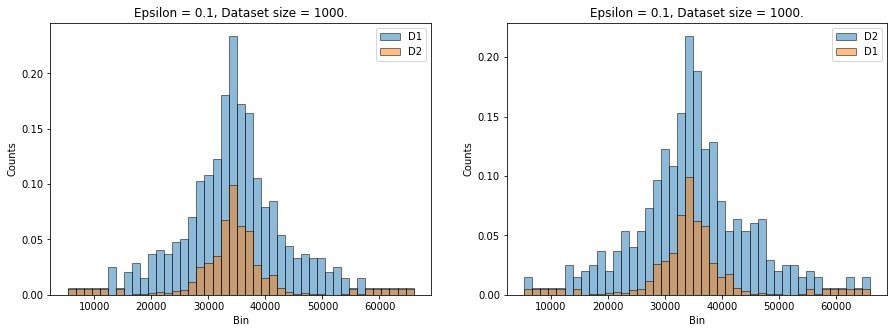

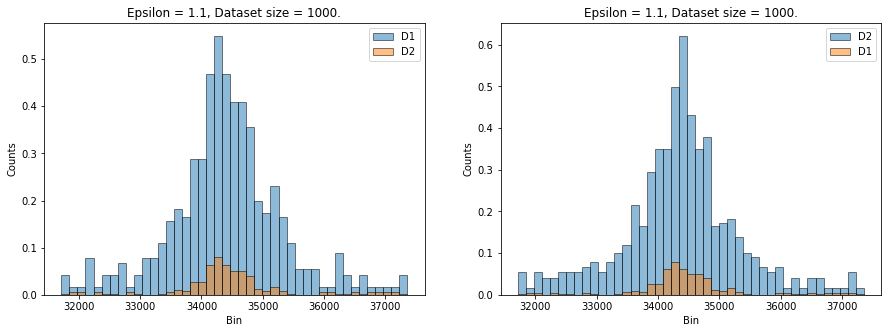

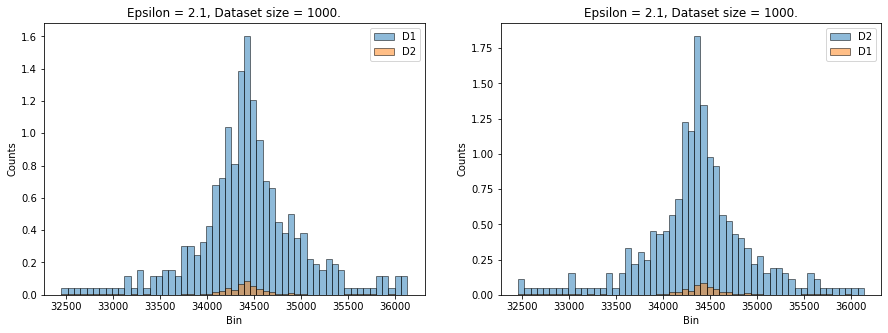

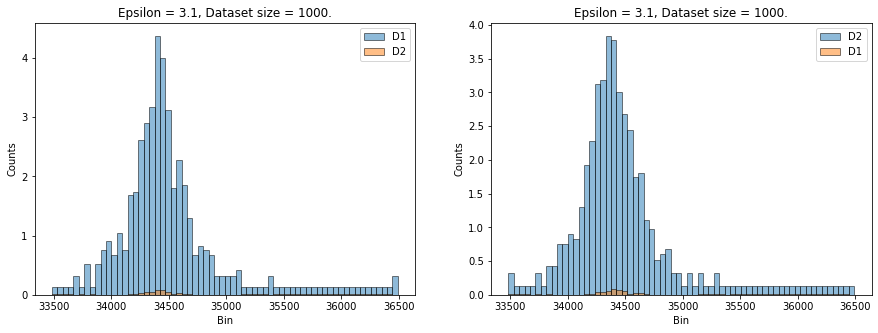

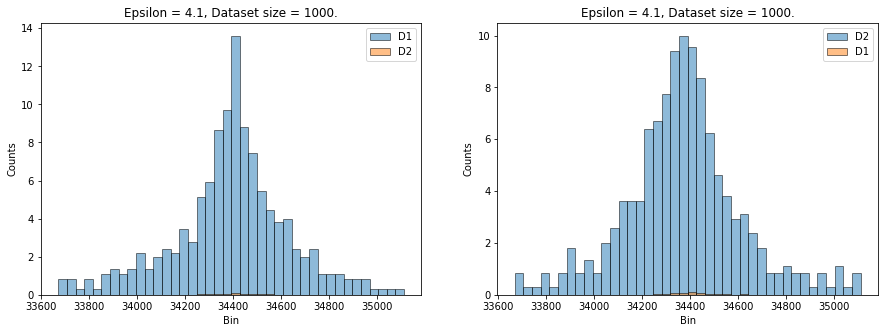

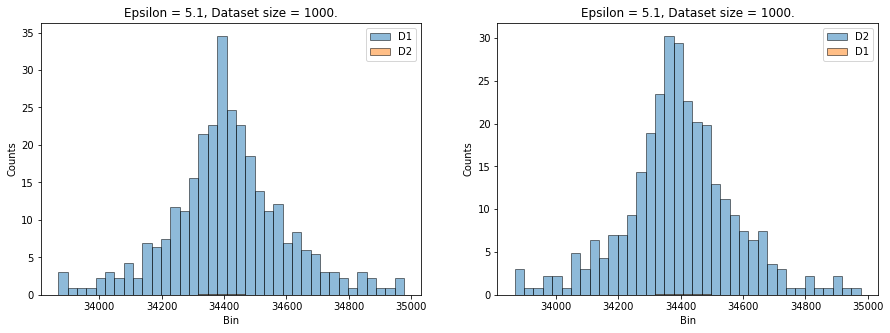

In [36]:
## 1. WhiteNoise-Core

for eps in epsilon:
    d1_wn = []
    d2_wn = []
    for i in range(iters):
        element1 = dp_mean_wn(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        element2 = dp_mean_wn(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n999.csv")
        d1_wn.append(element1)
        d2_wn.append(element2)
    temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
    c1_wn = temp_hist[0]
    c2_wn = temp_hist[1]
    binlist_wn = temp_hist[3]
    bounded_hist_wn = get_bounded_histogram(c1_wn, c2_wn, binlist_wn, len(d1_wn), len(d2_wn), eps)
    plot_histogram_neighbors(d1_wn, d2_wn, bounded_hist_wn[2], bounded_hist_wn[3], c1_wn, c2_wn, \
        bounded_hist_wn[6], bounded_hist_wn[7], binlist_wn, eps, 1000)




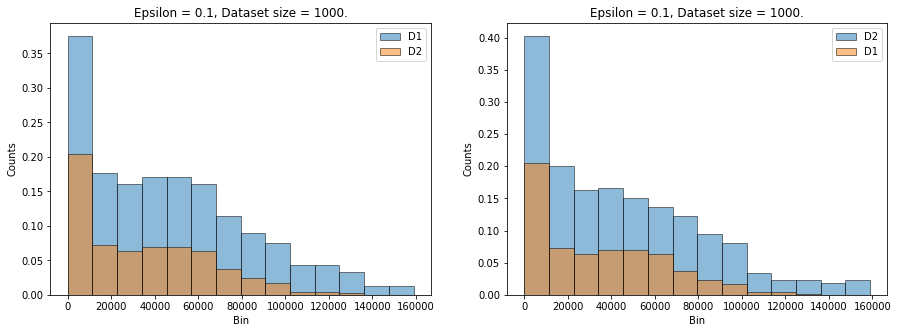

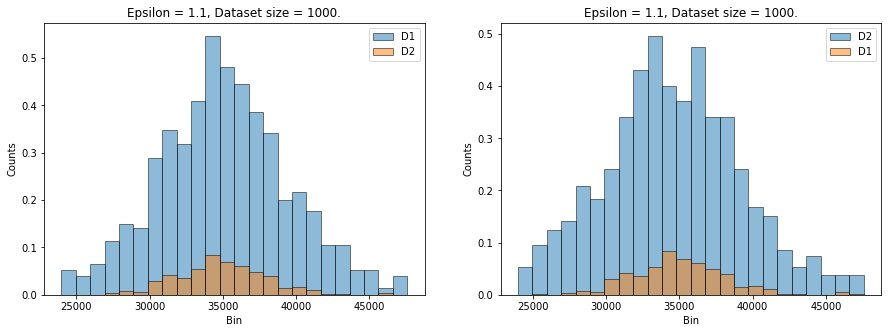

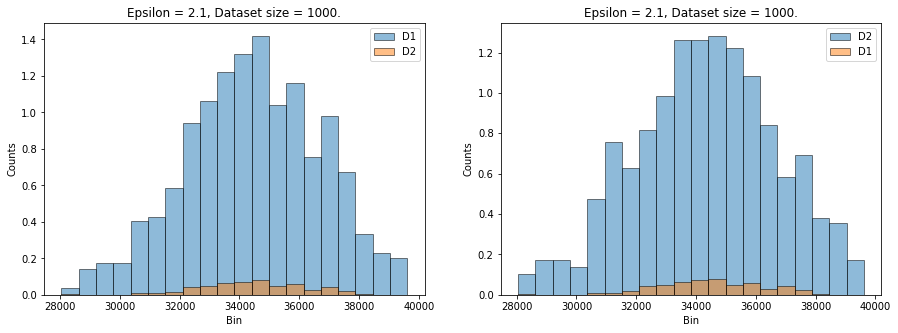

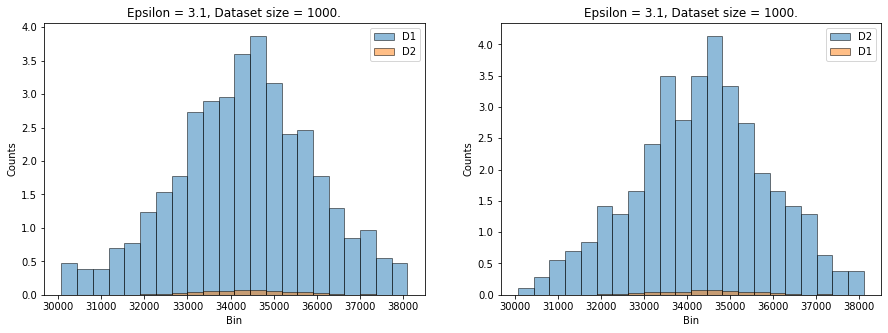

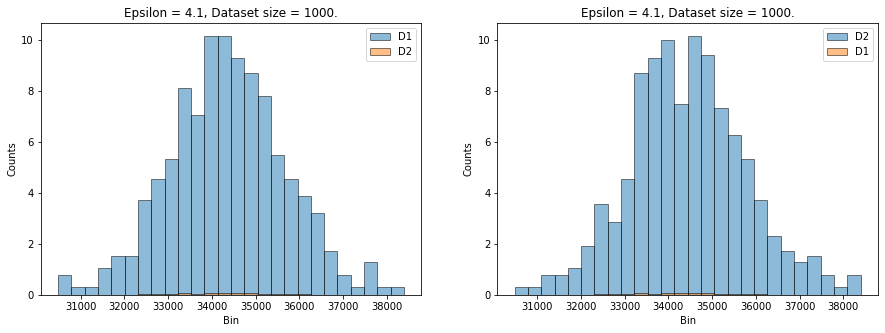

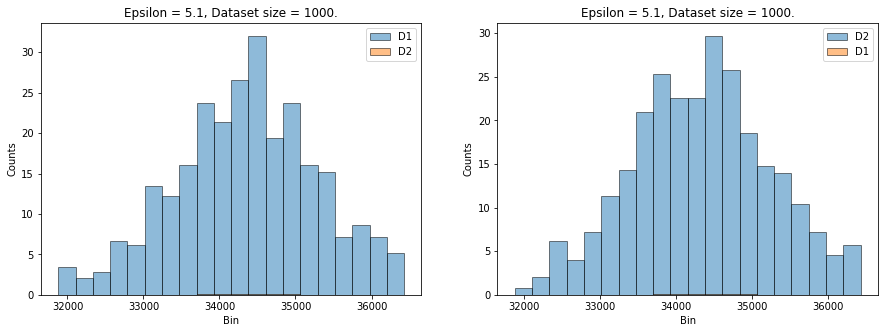

In [37]:
## 2. WhiteNoise-System

for eps in epsilon:
    d1_ws = []
    d2_ws = []
    for i in range(iters):
        element1 = dp_mean_ws(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n1000.csv")
        element2 = dp_mean_ws(eps, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n999.csv")
        d1_ws.append(element1)
        d2_ws.append(element2)
    temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
    c1_ws = temp_hist[0]
    c2_ws = temp_hist[1]
    binlist_ws = temp_hist[3]
    bounded_hist_ws = get_bounded_histogram(c1_ws, c2_ws, binlist_ws, len(d1_ws), len(d2_ws), eps)
    plot_histogram_neighbors(d1_ws, d2_ws, bounded_hist_ws[2], bounded_hist_ws[3], c1_ws, c2_ws, \
        bounded_hist_ws[6], bounded_hist_ws[7], binlist_ws, eps, 1000)

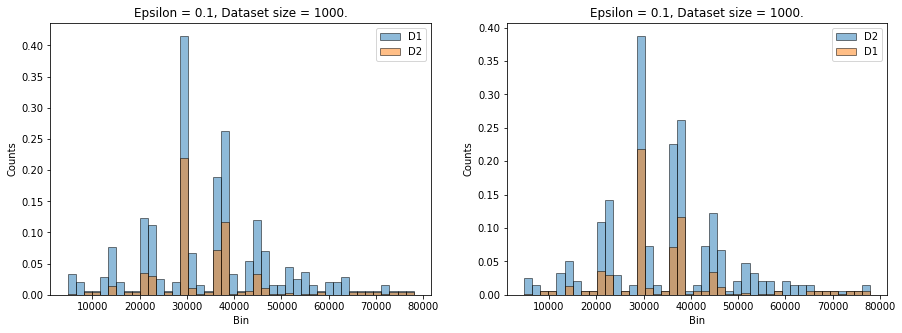

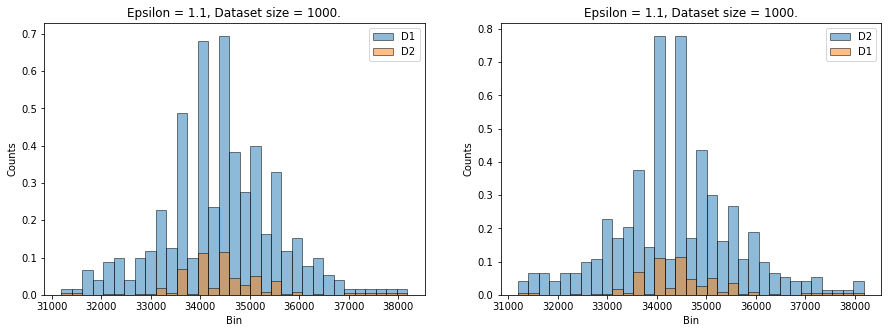

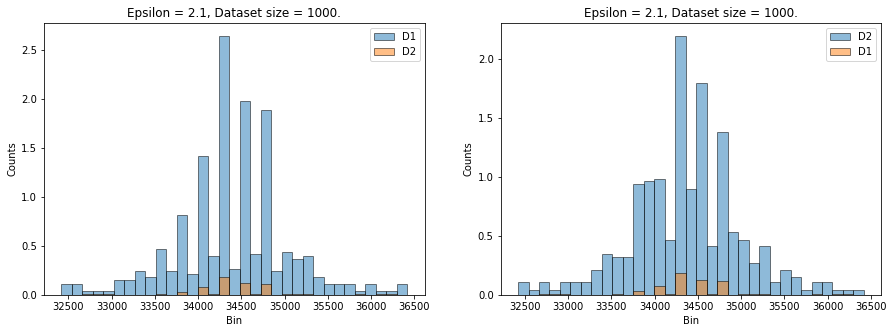

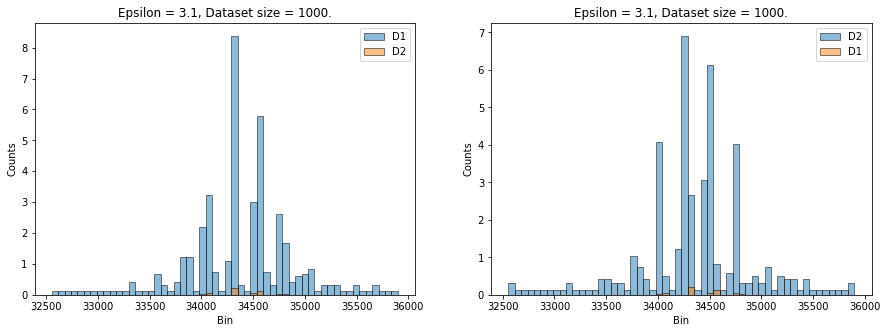

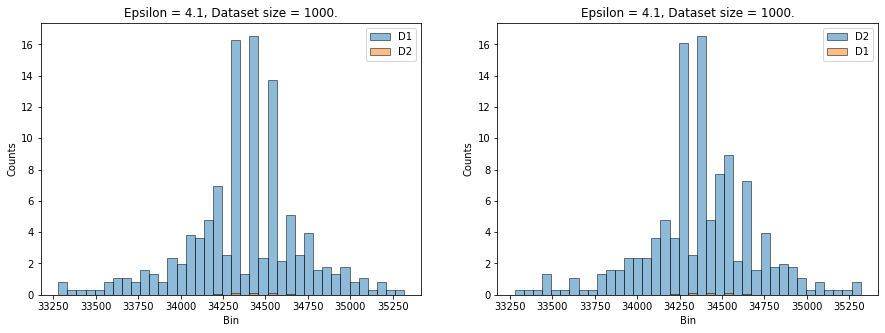

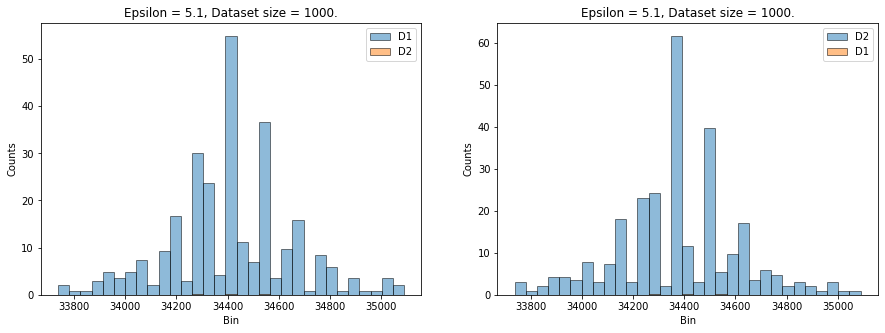

In [38]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)
idx_eps = 0
for eps in epsilon:
    d1_go = list(google_result[:][idx_eps*3 + 2])
    d2_go = list(google_result2[:][idx_eps*3 + 2])
    temp_hist = generate_histogram_neighbors(d1_go, d2_go)
    c1_go = temp_hist[0]
    c2_go = temp_hist[1]
    binlist_go = temp_hist[3]
    bounded_hist_go = get_bounded_histogram(c1_go, c2_go, binlist_go, len(d1_go), len(d2_go), eps)
    plot_histogram_neighbors(d1_go, d2_go, bounded_hist_go[2], bounded_hist_go[3], c1_go, c2_go, \
        bounded_hist_go[6], bounded_hist_go[7], binlist_go, eps, 1000)
    idx_eps = idx_eps + 1


### DP Testing vs Dataset size

We set up dataset size ranging from $10$ to $1000$ increasing by power of $10$. For each $\epsilon$ value, we repeat each DP algorithm 500 times. $\epsilon$ here we use is $1.0$.

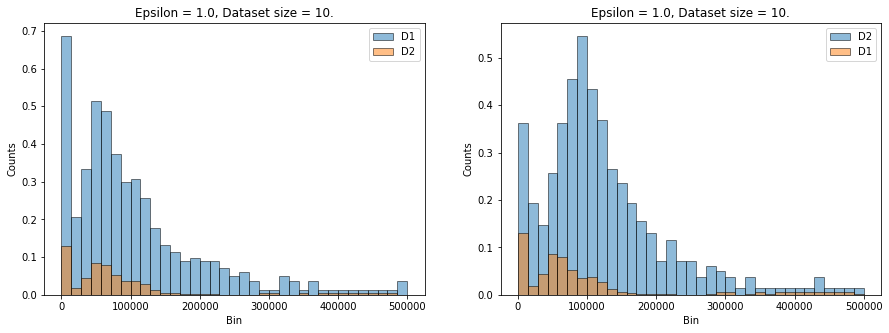

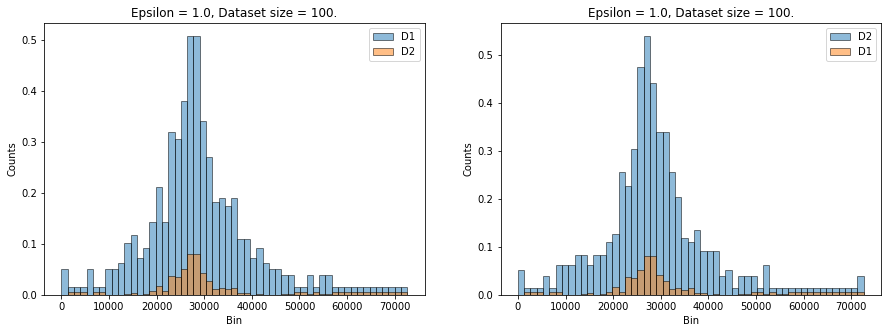

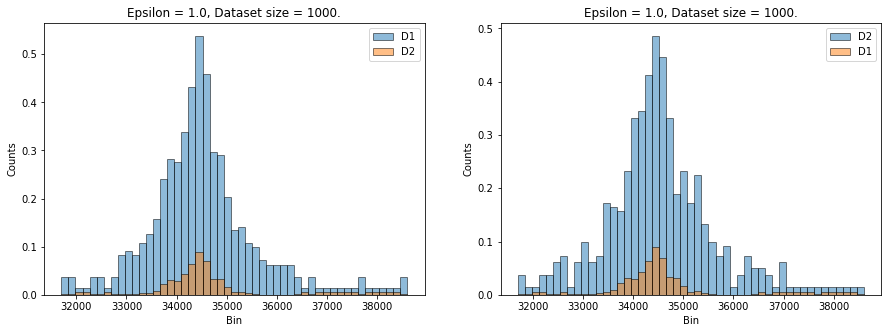

In [39]:
## 1. WhiteNoise-Core

for n in dataset_size:
    d1_wn = []
    d2_wn = []
    for i in range(iters):
        element1 = dp_mean_wn(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        element2 = dp_mean_wn(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
        d1_wn.append(element1)
        d2_wn.append(element2)
    temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
    c1_wn = temp_hist[0]
    c2_wn = temp_hist[1]
    binlist_wn = temp_hist[3]
    bounded_hist_wn = get_bounded_histogram(c1_wn, c2_wn, binlist_wn, len(d1_wn), len(d2_wn), 1.0)
    plot_histogram_neighbors(d1_wn, d2_wn, bounded_hist_wn[2], bounded_hist_wn[3], c1_wn, c2_wn, \
        bounded_hist_wn[6], bounded_hist_wn[7], binlist_wn, 1.0, n)

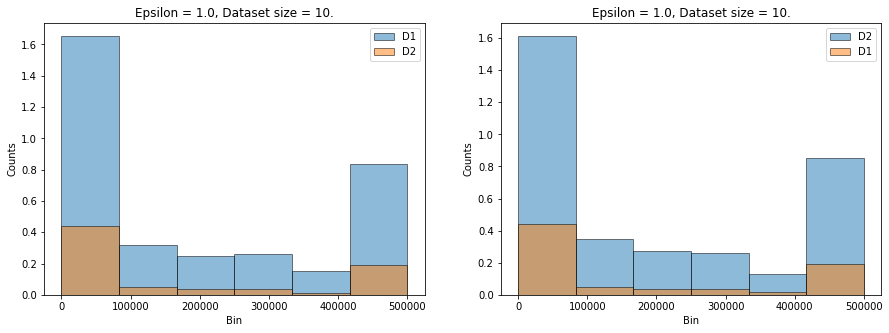

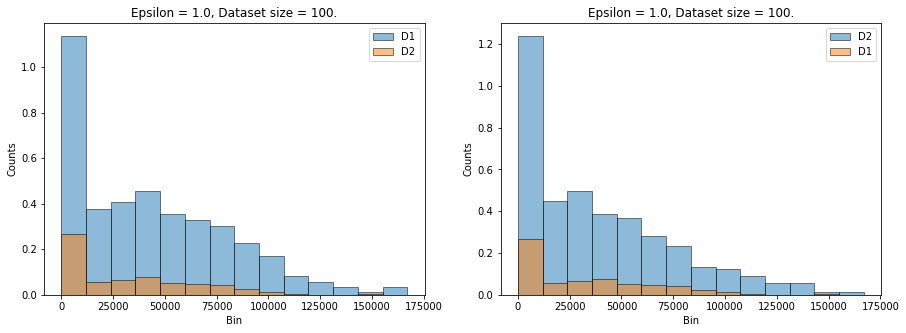

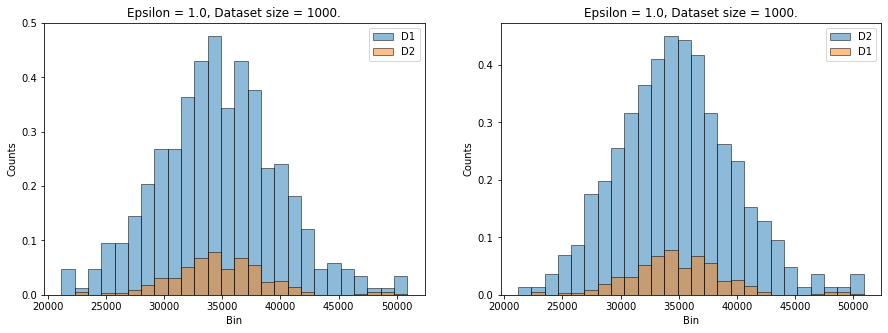

In [40]:
## 2. WhiteNoise-System

for n in dataset_size:
    d1_ws = []
    d2_ws = []
    for i in range(iters):
        element1 = dp_mean_ws(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
        element2 = dp_mean_ws(1.0, dp = "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
        d1_ws.append(element1)
        d2_ws.append(element2)
    temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
    c1_ws = temp_hist[0]
    c2_ws = temp_hist[1]
    binlist_ws = temp_hist[3]
    bounded_hist_ws = get_bounded_histogram(c1_ws, c2_ws, binlist_ws, len(d1_ws), len(d2_ws), 1.0)
    plot_histogram_neighbors(d1_ws, d2_ws, bounded_hist_ws[2], bounded_hist_ws[3], c1_ws, c2_ws, \
        bounded_hist_ws[6], bounded_hist_ws[7], binlist_ws, 1.0, n)

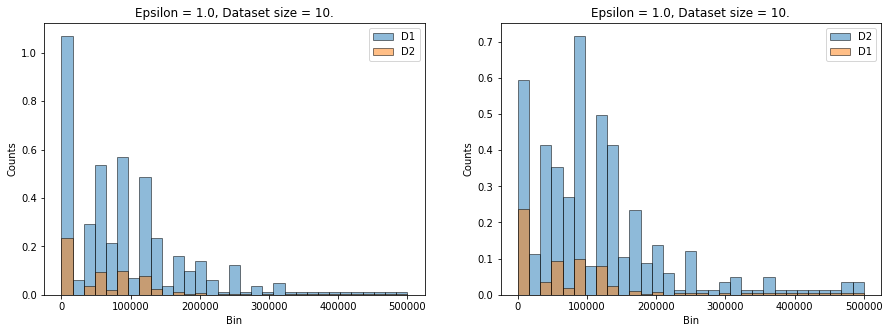

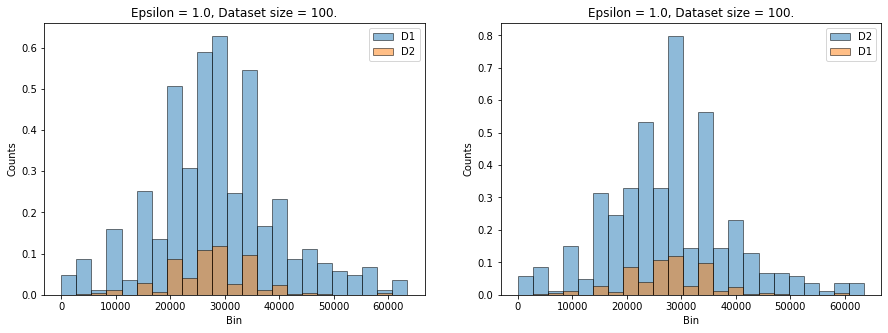

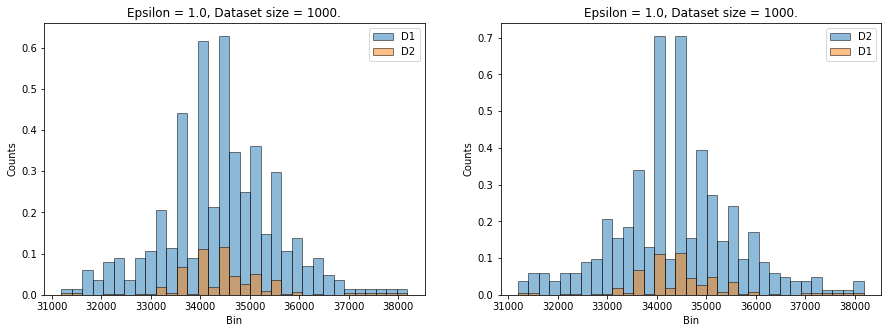

In [41]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)
idx_n = 0
for n in dataset_size:
    d1_go = list(google_result[:][3 + idx_n])
    d2_go = list(google_result2[:][3 + idx_n])
    temp_hist = generate_histogram_neighbors(d1_go, d2_go)
    c1_go = temp_hist[0]
    c2_go = temp_hist[1]
    binlist_go = temp_hist[3]
    bounded_hist_go = get_bounded_histogram(c1_go, c2_go, binlist_go, len(d1_go), len(d2_go), 1.0)
    plot_histogram_neighbors(d1_go, d2_go, bounded_hist_go[2], bounded_hist_go[3], c1_go, c2_go, \
        bounded_hist_go[6], bounded_hist_go[7], binlist_go, 1.0, n)
    idx_n = idx_n + 1

## 2D bubble plots or 3D surface plots

We now try to create 2D bubble plots with a range of epsilon values as x-axis and a range of dataset sizes as y-axis. We try MSE (Mean Squared Error) and Jenson-Shannon Divergence as our metrics of the sizes of the bubbles.

### 2D bubble plot or 3D surface plot under MSE


In [12]:
df1 = pd.DataFrame({"eps": epsilon, "key": ["a"]*len(epsilon)})
df2 = pd.DataFrame({"n": dataset_size, "key": ["a"]*len(dataset_size)})

In [13]:
## 1. WhiteNoise-Core

df_3d_mse_wn = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_mse_wn = []
for eps in epsilon:
    for n in dataset_size:
        income_mean_each = []
        for i in range(iters):
            element = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            income_mean_each.append(element)
        income_3d_mse_wn.append(np.mean((income_mean_each - np.mean(income))**2))

df_3d_mse_wn = df_3d_mse_wn.assign(mse = income_3d_mse_wn)
print("WhiteNoise-Core MSE vs (Epsilon and Dataset Size): \n", df_3d_mse_wn)


WhiteNoise-Core MSE vs (Epsilon and Dataset Size): 
     eps     n           mse
0   0.1    10  7.370389e+10
1   0.1   100  2.181633e+09
2   0.1  1000  4.586223e+07
3   1.1    10  6.455933e+09
4   1.1   100  9.335738e+07
5   1.1  1000  4.189299e+05
6   2.1    10  4.651757e+09
7   2.1   100  5.565289e+07
8   2.1  1000  1.132518e+05
9   3.1    10  3.944760e+09
10  3.1   100  5.123522e+07
11  3.1  1000  5.072730e+04
12  4.1    10  3.588131e+09
13  4.1   100  4.827804e+07
14  4.1  1000  3.150727e+04
15  5.1    10  3.465339e+09
16  5.1   100  4.562752e+07
17  5.1  1000  2.240603e+04


In [14]:
## 2. WhiteNoise-System

df_3d_mse_ws = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_mse_ws = []
for eps in epsilon:
    for n in dataset_size:
        income_mean_each = []
        for i in range(iters):
            element = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            income_mean_each.append(element)
        income_3d_mse_ws.append(np.mean((income_mean_each - np.mean(income))**2))

df_3d_mse_ws = df_3d_mse_ws.assign(mse = income_3d_mse_ws)
print("WhiteNoise-System MSE vs (Epsilon and Dataset Size): \n", df_3d_mse_ws)


WhiteNoise-System MSE vs (Epsilon and Dataset Size): 
     eps     n           mse
0   0.1    10  8.643996e+10
1   0.1   100  5.506177e+10
2   0.1  1000  1.191860e+09
3   1.1    10  7.105592e+10
4   1.1   100  1.009773e+09
5   1.1  1000  1.438817e+07
6   2.1    10  3.618017e+10
7   2.1   100  3.902825e+08
8   2.1  1000  4.695920e+06
9   3.1    10  2.638494e+10
10  3.1   100  2.096470e+08
11  3.1  1000  2.010451e+06
12  4.1    10  1.448315e+10
13  4.1   100  1.654155e+08
14  4.1  1000  1.078441e+06
15  5.1    10  1.167695e+10
16  5.1   100  1.129406e+08
17  5.1  1000  6.478328e+05


In [15]:
## 3. Google C++

df_3d_mse_go = pd.merge(df1, df2, on = "key")[["eps", "n"]]

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)

income_3d_mse_go = []
idx_eps = 0
for eps in epsilon:
    idx_n = 0
    for n in dataset_size:
        income_mean_each = list(google_result[:][idx_eps*3 + idx_n])
        income_3d_mse_go.append(np.mean((income_mean_each - np.mean(income))**2))
        idx_n = idx_n + 1
    idx_eps = idx_eps + 1

df_3d_mse_go = df_3d_mse_go.assign(mse = income_3d_mse_go)
print("Google C++ MSE vs (Epsilon and Dataset size): \n", df_3d_mse_go)


Google C++ MSE vs (Epsilon and Dataset size): 
     eps     n           mse
0   0.1    10  6.301031e+10
1   0.1   100  3.907847e+09
2   0.1  1000  9.186117e+07
3   1.1    10  7.971273e+09
4   1.1   100  1.305227e+08
5   1.1  1000  9.134913e+05
6   2.1    10  4.606142e+09
7   2.1   100  6.989455e+07
8   2.1  1000  2.089613e+05
9   3.1    10  3.979082e+09
10  3.1   100  5.794171e+07
11  3.1  1000  1.026869e+05
12  4.1    10  3.689290e+09
13  4.1   100  5.118491e+07
14  4.1  1000  5.359218e+04
15  5.1    10  3.651918e+09
16  5.1   100  5.108423e+07
17  5.1  1000  3.258544e+04


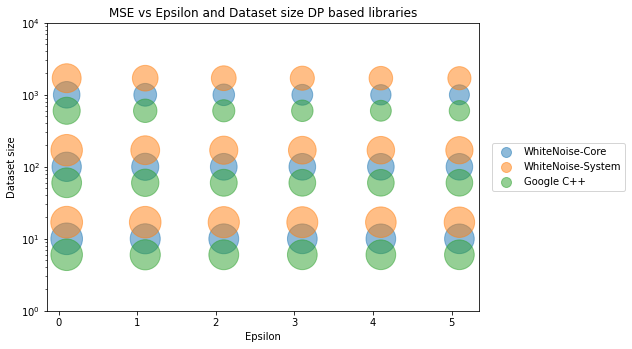

In [16]:
## Plotting for 2D bubble plot -- MSE

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(df_3d_mse_wn['eps'], df_3d_mse_wn['n'], s = np.log(df_3d_mse_wn['mse'])*40, cmap = "red", alpha = 0.5, label = "WhiteNoise-Core")
ax.scatter(df_3d_mse_ws['eps'], df_3d_mse_ws['n'] + [7, 70, 700]*6, s = np.log(df_3d_mse_ws['mse'])*40, cmap = "blue", alpha = 0.5, label = "WhiteNoise-System")
ax.scatter(df_3d_mse_go['eps'], df_3d_mse_go['n'] - [4, 40, 400]*6, s = np.log(df_3d_mse_go['mse'])*40, cmap = "green", alpha = 0.5, label = "Google C++")
lgnd = plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1, numpoints=1, fontsize=10)
#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.yscale('log')
plt.ylim(1, 10**4)
plt.xlabel('Epsilon')
plt.ylabel('Dataset size')
plt.title('MSE vs Epsilon and Dataset size DP based libraries')
plt.show()



Another way to showcase this scenario is 3D surface plot.

In [17]:
## Set up Chart Studio
username = 'JerryYnot'
api_key = 'I6DzZpwwoalh3VSRrlIy'
tls.set_credentials_file(username=username, api_key=api_key)


In [18]:
## 3D surface plot of MSE

z1 = df_3d_mse_wn[['mse']].to_numpy().reshape(len(epsilon), len(dataset_size))
z2 = df_3d_mse_ws[['mse']].to_numpy().reshape(len(epsilon), len(dataset_size))
z3 = df_3d_mse_go[['mse']].to_numpy().reshape(len(epsilon), len(dataset_size))

colors_wn = np.zeros(shape = z1.shape)
colors_ws = np.zeros(shape = z2.shape) + 0.5
colors_go = np.ones(shape = z3.shape)

colorscale = [[0, 'rgb(255, 0, 0)'], [1, 'rgb(0, 255, 0)']]

fig = go.Figure(data=[
    go.Surface(z=np.log10(z1)/100, x=np.log10(dataset_size), y=epsilon, text = z1, name = "WhiteNoise-Core",
               surfacecolor=colors_wn, cmin = 0, cmax = 1, colorscale = colorscale),
    go.Surface(z=np.log10(z2)/100, x=np.log10(dataset_size), y=epsilon, text = z2, name = "WhiteNoise-System",
               surfacecolor=colors_ws, cmin = 0, cmax = 1, colorscale = colorscale),
    go.Surface(z=np.log10(z3)/100, x=np.log10(dataset_size), y=epsilon, text = z3, name = "Google C++",
               surfacecolor=colors_go, cmin = 0, cmax = 1, colorscale = colorscale)
])

fig.update_layout(title_text = "MSE 3D plot",
                  scene = dict(
                    xaxis_title = 'Dataset Size',
                    yaxis_title = 'Epsilon',
                    zaxis_title = 'MSE',
                    xaxis = dict(
                        ticktext= ['10', '100', '1000'],
                        tickvals= [1, 2, 3],
                        range = [0.5, 3.5]),
                    zaxis = dict(
                        ticktext= ['10^4', '10^6', '10^8', '10^10'],
                        tickvals= [0.04, 0.06, 0.08, 0.1],
                        range = [0.03, 0.11])))

fig.update_traces(showscale=False)

py.plot(fig, filename="MSE 3D Surface", auto_open=False)

fig.show()

From both 2D bubble plot and 3D surface plot, we can see all libraries follow similar patterns, when epsilon increases MSE decreases and when dataset size increases MSE decreases. WhiteNoise-System keeps the largest MSE for most scenarios. And we know smaller MSE means higher accuracy.

### 2D bubble plot or 3D surface plot under Jenson-Shannon Divergence

In [19]:
## 1. WhiteNoise-Core

df_3d_js_wn = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_wn = []

for eps in epsilon:
    for n in dataset_size:
        d1_wn = []
        d2_wn = []
        for i in range(iters):
            element1 = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_wn.append(element1)
            d2_wn.append(element2)
        temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
        c1_wn = temp_hist[0]
        c2_wn = temp_hist[1]
        p1_wn_temp = c1_wn / np.sum(c1_wn)
        p2_wn_temp = c2_wn / np.sum(c2_wn)
        p1_wn = [p1_wn_temp[i] for i in range(len(p1_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        p2_wn = [p2_wn_temp[i] for i in range(len(p2_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        income_3d_js_wn.append(JSD(p1_wn, p2_wn))

df_3d_js_wn = df_3d_js_wn.assign(js = income_3d_js_wn)
print("WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_wn)

WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.004355
1   0.1   100  0.017486
2   0.1  1000  0.016535
3   1.1    10  0.050086
4   1.1   100  0.019826
5   1.1  1000  0.024544
6   2.1    10  0.107203
7   2.1   100  0.015138
8   2.1  1000  0.022303
9   3.1    10  0.170362
10  3.1   100  0.017631
11  3.1  1000  0.021843
12  4.1    10  0.249791
13  4.1   100  0.029768
14  4.1  1000  0.021385
15  5.1    10  0.342372
16  5.1   100  0.023023
17  5.1  1000  0.028806


In [20]:
## 2. WhiteNoise-System

df_3d_js_ws = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_ws = []

for eps in epsilon:
    for n in dataset_size:
        d1_ws = []
        d2_ws = []
        for i in range(iters):
            element1 = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_ws.append(element1)
            d2_ws.append(element2)
        temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
        c1_ws = temp_hist[0]
        c2_ws = temp_hist[1]
        p1_ws_temp = c1_ws / np.sum(c1_ws)
        p2_ws_temp = c2_ws / np.sum(c2_ws)
        p1_ws = [p1_ws_temp[i] for i in range(len(p1_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        p2_ws = [p2_ws_temp[i] for i in range(len(p2_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        income_3d_js_ws.append(JSD(p1_ws, p2_ws))

df_3d_js_ws = df_3d_js_ws.assign(js = income_3d_js_ws)
print("WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_ws)

WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.002582
1   0.1   100  0.004455
2   0.1  1000  0.007639
3   1.1    10  0.001038
4   1.1   100  0.011168
5   1.1  1000  0.015809
6   2.1    10  0.007837
7   2.1   100  0.005247
8   2.1  1000  0.016464
9   3.1    10  0.010167
10  3.1   100  0.006967
11  3.1  1000  0.021090
12  4.1    10  0.009511
13  4.1   100  0.007626
14  4.1  1000  0.019380
15  5.1    10  0.021533
16  5.1   100  0.012732
17  5.1  1000  0.005883


In [21]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)

df_3d_js_go = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_go = []

idx_eps = 0
idx_n = 0
for eps in epsilon:
    for n in dataset_size:
        d1_go = list(google_result[:][idx_eps*3 + idx_n])
        d2_go = list(google_result2[:][idx_eps*3 + idx_n])
        temp_hist = generate_histogram_neighbors(d1_go, d2_go)
        c1_go = temp_hist[0]
        c2_go = temp_hist[1]
        p1_go_temp = c1_go / np.sum(c1_go)
        p2_go_temp = c2_go / np.sum(c2_go)
        p1_go = [p1_go_temp[i] for i in range(len(p1_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        p2_go = [p2_go_temp[i] for i in range(len(p2_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        income_3d_js_go.append(JSD(p1_go, p2_go))
        idx_n = idx_n + 1
    idx_n = 0
    idx_eps = idx_eps + 1

df_3d_js_go = df_3d_js_go.assign(js = income_3d_js_go)
print("Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_go)

Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.004268
1   0.1   100  0.010496
2   0.1  1000  0.014371
3   1.1    10  0.034940
4   1.1   100  0.029819
5   1.1  1000  0.033175
6   2.1    10  0.059678
7   2.1   100  0.070867
8   2.1  1000  0.046016
9   3.1    10  0.136002
10  3.1   100  0.185124
11  3.1  1000  0.258544
12  4.1    10  0.220381
13  4.1   100  0.220051
14  4.1  1000  0.210330
15  5.1    10  0.297765
16  5.1   100  0.333807
17  5.1  1000  0.334683


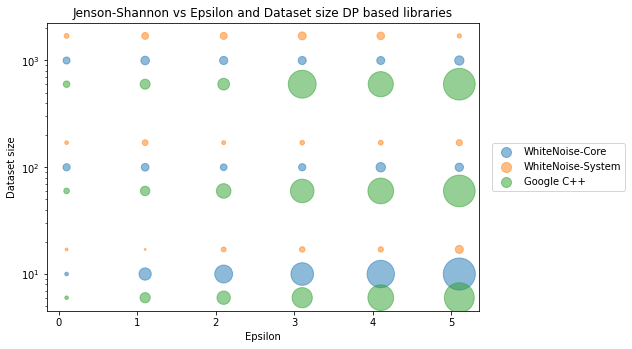

In [22]:
## Plotting for 2D bubble plot for Jenson-Shannon Divergence

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(df_3d_js_wn['eps'], df_3d_js_wn['n'], s = (df_3d_js_wn['js'])*3000, cmap = "red", alpha = 0.5, label = "WhiteNoise-Core")
ax.scatter(df_3d_js_ws['eps'], df_3d_js_ws['n'] + [7, 70, 700]*6, s = (df_3d_js_ws['js'])*3000, cmap = "blue", alpha = 0.5, label = "WhiteNoise-System")
ax.scatter(df_3d_js_go['eps'], df_3d_js_go['n'] - [4, 40, 400]*6, s = (df_3d_js_go['js'])*3000, cmap = "green", alpha = 0.5, label = "Google C++")
lgnd = plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1, numpoints=1, fontsize=10)
#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.yscale('log')
#plt.ylim(1, 10**4)
plt.xlabel('Epsilon')
plt.ylabel('Dataset size')
plt.title('Jenson-Shannon vs Epsilon and Dataset size DP based libraries')

plt.show()

In [36]:
## 3D surface plot of JS Divergence

z1 = df_3d_js_wn[['js']].to_numpy().reshape(len(epsilon), len(dataset_size))
z2 = df_3d_js_ws[['js']].to_numpy().reshape(len(epsilon), len(dataset_size))
z3 = df_3d_js_go[['js']].to_numpy().reshape(len(epsilon), len(dataset_size))

colors_wn = np.zeros(shape = z1.shape)
colors_ws = np.zeros(shape = z2.shape) + 0.5
colors_go = np.ones(shape = z3.shape)

colorscale = [[0, 'rgb(255, 0, 0)'], [1, 'rgb(0, 255, 0)']]

fig = go.Figure(data=[
    go.Surface(z=z1, x=np.log10(dataset_size), y=epsilon, name = "WhiteNoise-Core",
               surfacecolor=colors_wn, cmin = 0, cmax = 1, colorscale = colorscale),
    go.Surface(z=z2, x=np.log10(dataset_size), y=epsilon, name = "WhiteNoise-System",
               surfacecolor=colors_ws, cmin = 0, cmax = 1, colorscale = colorscale),
    go.Surface(z=z3, x=np.log10(dataset_size), y=epsilon, name = "Google C++",
               surfacecolor=colors_go, cmin = 0, cmax = 1, colorscale = colorscale)
])

fig.update_layout(title_text = "Jensen-Shannon Divergence 3D plot",
                  scene = dict(
                    xaxis_title = 'Dataset Size',
                    yaxis_title = 'Epsilon',
                    zaxis_title = 'JS Divergence',
                    xaxis = dict(
                        ticktext= ['10', '100', '1000'],
                        tickvals= [1, 2, 3],
                        range = [0.5, 3.5]),
                    zaxis = dict(
                        ticktext= ['0', '0.1', '0.2', '0.3'],
                        tickvals= [0, 0.1, 0.2, 0.3],
                        range = [-0.05, 0.35])))

fig.update_traces(showscale=False)

py.plot(fig, filename="JS 3D Surface", auto_open=False)

fig.show()

From both 2D bubble plot and 3D surface plot, we can see JS divergence increases when epsilon increases or dataset size increases, especially for _Google C++_ (but not obviors for _WhiteNoise-System_).

Note that _WhiteNoise-System_ show smaller JS divergences than _WhiteNoise-Core_ and _Google C++_ for most cases. We know larger JS divergence means more distinct two distributions, hence less private of the aggregation results.

## One more dimension?

Let's try something even more interesting. Try to add one more dimension, aggregation method. Here we select `MEAN`, `SUM` and `COUNT`.

One way to visualize this is to create a 3D plot containing all information we need.


In [24]:
# set aggregation types

aggr_type = ["MEAN", "SUM", "COUNT"]

df3 = pd.DataFrame({"aggr": aggr_type, "key": ["a"]*len(aggr_type)})

temp = pd.merge(df3, df1, on = "key")[["aggr", "eps", "key"]]
df_4d_js_wn = pd.merge(temp, df2, on = "key")[["aggr", "eps", "n"]]
df_4d_js_ws = df_4d_js_wn.copy()
df_4d_js_go = df_4d_js_wn.copy()

In [25]:
### SUM

## 1. WhiteNoise-Core

df_3d_js_wn2 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_wn = []

for eps in epsilon:
    for n in dataset_size:
        d1_wn = []
        d2_wn = []
        for i in range(iters):
            element1 = dp_sum_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_sum_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_wn.append(element1)
            d2_wn.append(element2)
        temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
        c1_wn = temp_hist[0]
        c2_wn = temp_hist[1]
        p1_wn_temp = c1_wn / np.sum(c1_wn)
        p2_wn_temp = c2_wn / np.sum(c2_wn)
        p1_wn = [p1_wn_temp[i] for i in range(len(p1_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        p2_wn = [p2_wn_temp[i] for i in range(len(p2_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        income_3d_js_wn.append(JSD(p1_wn, p2_wn))

df_3d_js_wn2 = df_3d_js_wn2.assign(js = income_3d_js_wn)
print("WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_wn2)



WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.001294
1   0.1   100  0.008207
2   0.1  1000  0.027109
3   1.1    10  0.075825
4   1.1   100  0.018391
5   1.1  1000  0.021920
6   2.1    10  0.160774
7   2.1   100  0.028870
8   2.1  1000  0.026984
9   3.1    10  0.237941
10  3.1   100  0.024476
11  3.1  1000  0.026073
12  4.1    10  0.377028
13  4.1   100  0.032040
14  4.1  1000  0.021676
15  5.1    10  0.414116
16  5.1   100  0.021292
17  5.1  1000  0.029780


In [26]:
## 2. WhiteNoise-System

df_3d_js_ws2 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_ws = []

for eps in epsilon:
    for n in dataset_size:
        d1_ws = []
        d2_ws = []
        for i in range(iters):
            element1 = dp_sum_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_sum_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_ws.append(element1)
            d2_ws.append(element2)
        temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
        c1_ws = temp_hist[0]
        c2_ws = temp_hist[1]
        p1_ws_temp = c1_ws / np.sum(c1_ws)
        p2_ws_temp = c2_ws / np.sum(c2_ws)
        p1_ws = [p1_ws_temp[i] for i in range(len(p1_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        p2_ws = [p2_ws_temp[i] for i in range(len(p2_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        income_3d_js_ws.append(JSD(p1_ws, p2_ws))

df_3d_js_ws2 = df_3d_js_ws2.assign(js = income_3d_js_ws)
print("WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_ws2)




WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.006365
1   0.1   100  0.004218
2   0.1  1000  0.004446
3   1.1    10  0.003935
4   1.1   100  0.007569
5   1.1  1000  0.012977
6   2.1    10  0.025207
7   2.1   100  0.006234
8   2.1  1000  0.010182
9   3.1    10  0.008232
10  3.1   100  0.011058
11  3.1  1000  0.010077
12  4.1    10  0.013066
13  4.1   100  0.010796
14  4.1  1000  0.015623
15  5.1    10  0.020518
16  5.1   100  0.007625
17  5.1  1000  0.008056


In [27]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)

df_3d_js_go2 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_go = []

idx_eps = 0
idx_n = 0
for eps in epsilon:
    for n in dataset_size:
        d1_go = list(google_result[:][idx_eps*3 + idx_n])
        d1_go = np.clip(d1_go, 0, 500000)
        d2_go = list(google_result2[:][idx_eps*3 + idx_n])
        d2_go = np.clip(d2_go, 0, 500000)
        temp_hist = generate_histogram_neighbors(d1_go, d2_go)
        c1_go = temp_hist[0]
        c2_go = temp_hist[1]
        p1_go_temp = c1_go / np.sum(c1_go)
        p2_go_temp = c2_go / np.sum(c2_go)
        p1_go = [p1_go_temp[i] for i in range(len(p1_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        p2_go = [p2_go_temp[i] for i in range(len(p2_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        income_3d_js_go.append(JSD(p1_go, p2_go))
        idx_n = idx_n + 1
    idx_n = 0
    idx_eps = idx_eps + 1

df_3d_js_go2 = df_3d_js_go2.assign(js = income_3d_js_go)
print("Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_go2)




Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.004268
1   0.1   100  0.010496
2   0.1  1000  0.014371
3   1.1    10  0.034940
4   1.1   100  0.029819
5   1.1  1000  0.033175
6   2.1    10  0.059678
7   2.1   100  0.070867
8   2.1  1000  0.046016
9   3.1    10  0.136002
10  3.1   100  0.185124
11  3.1  1000  0.258544
12  4.1    10  0.220381
13  4.1   100  0.220051
14  4.1  1000  0.210330
15  5.1    10  0.297765
16  5.1   100  0.333807
17  5.1  1000  0.334683


In [28]:
### COUNT

## 1. WhiteNoise-Core

df_3d_js_wn3 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_wn = []

for eps in epsilon:
    for n in dataset_size:
        d1_wn = []
        d2_wn = []
        for i in range(iters):
            element1 = dp_count_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_count_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_wn.append(element1)
            d2_wn.append(element2)
        temp_hist = generate_histogram_neighbors(d1_wn, d2_wn)
        c1_wn = temp_hist[0]
        c2_wn = temp_hist[1]
        p1_wn_temp = c1_wn / np.sum(c1_wn)
        p2_wn_temp = c2_wn / np.sum(c2_wn)
        p1_wn = [p1_wn_temp[i] for i in range(len(p1_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        p2_wn = [p2_wn_temp[i] for i in range(len(p2_wn_temp)) if p1_wn_temp[i] + p2_wn_temp[i] != 0]
        income_3d_js_wn.append(JSD(p1_wn, p2_wn))

df_3d_js_wn3 = df_3d_js_wn3.assign(js = income_3d_js_wn)
print("WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_wn3)




WhiteNoise-Core Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.024180
1   0.1   100  0.031437
2   0.1  1000  0.016654
3   1.1    10  0.111346
4   1.1   100  0.129271
5   1.1  1000  0.069987
6   2.1    10  0.215930
7   2.1   100  0.250143
8   2.1  1000  0.243385
9   3.1    10  0.350396
10  3.1   100  0.381565
11  3.1  1000  0.357036
12  4.1    10  0.447199
13  4.1   100  0.455855
14  4.1  1000  0.490024
15  5.1    10  0.521084
16  5.1   100  0.507585
17  5.1  1000  0.510465


In [29]:
## 2. WhiteNoise-System

df_3d_js_ws3 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_ws = []

for eps in epsilon:
    for n in dataset_size:
        d1_ws = []
        d2_ws = []
        for i in range(iters):
            element1 = dp_count_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")
            element2 = dp_count_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n - 1) + ".csv")
            d1_ws.append(element1)
            d2_ws.append(element2)
        temp_hist = generate_histogram_neighbors(d1_ws, d2_ws)
        c1_ws = temp_hist[0]
        c2_ws = temp_hist[1]
        p1_ws_temp = c1_ws / np.sum(c1_ws)
        p2_ws_temp = c2_ws / np.sum(c2_ws)
        p1_ws = [p1_ws_temp[i] for i in range(len(p1_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        p2_ws = [p2_ws_temp[i] for i in range(len(p2_ws_temp)) if p1_ws_temp[i] + p2_ws_temp[i] != 0]
        income_3d_js_ws.append(JSD(p1_ws, p2_ws))

df_3d_js_ws3 = df_3d_js_ws3.assign(js = income_3d_js_ws)
print("WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_ws3)



WhiteNoise-System Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.007154
1   0.1   100  0.007074
2   0.1  1000  0.014834
3   1.1    10  0.008971
4   1.1   100  0.012155
5   1.1  1000  0.022254
6   2.1    10  0.023921
7   2.1   100  0.025307
8   2.1  1000  0.012217
9   3.1    10  0.027004
10  3.1   100  0.028574
11  3.1  1000  0.026025
12  4.1    10  0.043490
13  4.1   100  0.040386
14  4.1  1000  0.033315
15  5.1    10  0.053838
16  5.1   100  0.070873
17  5.1  1000  0.036164


In [30]:
## 3. Google C++

google_result = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results.csv", header = None)
google_result2 = pd.read_csv("/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/GoogleDP_3algorithms_results2.csv", header = None)

df_3d_js_go3 = pd.merge(df1, df2, on = "key")[["eps", "n"]]

income_3d_js_go = []

idx_eps = 0
idx_n = 0
for eps in epsilon:
    for n in dataset_size:
        d1_go = list(google_result[:][idx_eps*3 + idx_n + 36])
        d1_go = np.clip(d1_go, 0, 500000*n)
        d2_go = list(google_result2[:][idx_eps*3 + idx_n + 36])
        d2_go = np.clip(d2_go, 0, 500000*n)
        temp_hist = generate_histogram_neighbors(d1_go, d2_go)
        c1_go = temp_hist[0]
        c2_go = temp_hist[1]
        p1_go_temp = c1_go / np.sum(c1_go)
        p2_go_temp = c2_go / np.sum(c2_go)
        p1_go = [p1_go_temp[i] for i in range(len(p1_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        p2_go = [p2_go_temp[i] for i in range(len(p2_go_temp)) if p1_go_temp[i] + p2_go_temp[i] != 0]
        income_3d_js_go.append(JSD(p1_go, p2_go))
        idx_n = idx_n + 1
    idx_n = 0
    idx_eps = idx_eps + 1

df_3d_js_go3 = df_3d_js_go3.assign(js = income_3d_js_go)
print("Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): \n", df_3d_js_go3)




Google C++ Jenson-Shannon Divergence vs (Epsilon and Dataset Size): 
     eps     n        js
0   0.1    10  0.006956
1   0.1   100  0.008059
2   0.1  1000  0.003330
3   1.1    10  0.097790
4   1.1   100  0.106450
5   1.1  1000  0.098017
6   2.1    10  0.186962
7   2.1   100  0.214424
8   2.1  1000  0.191121
9   3.1    10  0.305024
10  3.1   100  0.350243
11  3.1  1000  0.314869
12  4.1    10  0.438183
13  4.1   100  0.403986
14  4.1  1000  0.445817
15  5.1    10  0.481946
16  5.1   100  0.517523
17  5.1  1000  0.471430


In [31]:
# Add library labels
df_4d_js_wn['js'] = df_3d_js_wn['js'].to_list() + df_3d_js_wn2['js'].to_list() + df_3d_js_wn3['js'].to_list()
df_4d_js_wn['lib'] = 'WhiteNoise-Core'

df_4d_js_ws['js'] = df_3d_js_ws['js'].to_list() + df_3d_js_ws2['js'].to_list() + df_3d_js_ws3['js'].to_list()
df_4d_js_ws['lib'] = 'WhiteNoise-System'

df_4d_js_go['js'] = df_3d_js_go['js'].to_list() + df_3d_js_go2['js'].to_list() + df_3d_js_go3['js'].to_list()
df_4d_js_go['lib'] = 'Google C++'

In [32]:
# Create final table
temp = df_4d_js_wn.append(df_4d_js_ws)
df_4d_js_comb = temp.append(df_4d_js_go)

In [37]:
## 3d plot for JS divergence

fig = px.scatter_3d(df_4d_js_comb, x='eps', y='n', z='aggr', color='lib', symbol='aggr', size='js', log_y=True, size_max=55, opacity=0.5, \
labels = {'eps': 'Epsilon', 'n': 'N', 'aggr': 'Aggregation', 'lib': 'Library'})

fig.update_layout(
    title_text = "3D plot for Jensen-Shannon Divergence",
    scene=dict(
        yaxis=dict(showticklabels=True, nticks = 3),
        zaxis=dict(showticklabels=False)
    )
)

py.plot(fig, filename="JS 3D plot", auto_open=False)

fig.show()

This 3D plot can give us a lot of information across a bench of different pairs of setups. For example, for aggregation `COUNT`, JS divergence increases when $\epsilon$ increases or dataset size increases. When keep the same $\epsilon$ and dataset size, `COUNT` seems to contain higher JS divergence than `MEAN` and `SUM`. Users can zoom and spin the 3D plot to get more information. However, it seems not so straightforward to visualize, or we can say, it still need users to be patient to zoom, to rotate to a right angle and to click out catogrical features that they are not interested in. So another way to showcase this multi-dimensional scenario is to align several 2D plots together as below.


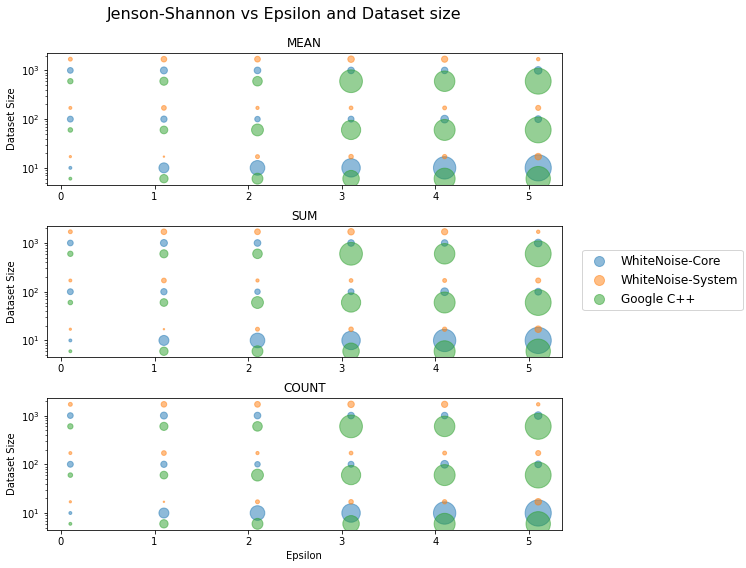

In [38]:
## Subplots of 2D bubbles

fig, axs = plt.subplots(3, 1)

fig.set_figheight(8)
fig.set_figwidth(8)

axs[0].scatter(df_3d_js_wn['eps'], df_3d_js_wn['n'], s = (df_3d_js_wn['js'])*2000, cmap = "red", alpha = 0.5, label = "WhiteNoise-Core")
axs[0].scatter(df_3d_js_ws['eps'], df_3d_js_ws['n'] + [7, 70, 700]*6, s = (df_3d_js_ws['js'])*2000, cmap = "blue", alpha = 0.5, label = "WhiteNoise-System")
axs[0].scatter(df_3d_js_go['eps'], df_3d_js_go['n'] - [4, 40, 400]*6, s = (df_3d_js_go['js'])*2000, cmap = "green", alpha = 0.5, label = "Google C++")
axs[0].set_title("MEAN", fontsize = 12)
axs[0].set_yscale("log")

axs[1].scatter(df_3d_js_wn2['eps'], df_3d_js_wn['n'], s = (df_3d_js_wn['js'])*2000, cmap = "red", alpha = 0.5)
axs[1].scatter(df_3d_js_ws2['eps'], df_3d_js_ws['n'] + [7, 70, 700]*6, s = (df_3d_js_ws['js'])*2000, cmap = "blue", alpha = 0.5)
axs[1].scatter(df_3d_js_go2['eps'], df_3d_js_go['n'] - [4, 40, 400]*6, s = (df_3d_js_go['js'])*2000, cmap = "green", alpha = 0.5)
axs[1].set_title("SUM", fontsize = 12)
axs[1].set_yscale("log")

axs[2].scatter(df_3d_js_wn3['eps'], df_3d_js_wn['n'], s = (df_3d_js_wn['js'])*2000, cmap = "red", alpha = 0.5)
axs[2].scatter(df_3d_js_ws3['eps'], df_3d_js_ws['n'] + [7, 70, 700]*6, s = (df_3d_js_ws['js'])*2000, cmap = "blue", alpha = 0.5)
axs[2].scatter(df_3d_js_go3['eps'], df_3d_js_go['n'] - [4, 40, 400]*6, s = (df_3d_js_go['js'])*2000, cmap = "green", alpha = 0.5)
axs[2].set_title("COUNT", fontsize = 12)
axs[2].set_yscale("log")

lgnd = fig.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1, numpoints=1, fontsize=12)
#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]

for ax in axs.flat:
    ax.set(ylabel='Dataset Size')

axs[2].set_xlabel("Epsilon")

fig.tight_layout()
fig.suptitle('Jenson-Shannon vs Epsilon and Dataset size', fontsize = 16)
fig.subplots_adjust(top=0.9)

plt.show()

These three bubble plots are just simply stacked together vertically, which enables us to compare across different parameters althrough comparing across different aggregation types seems not so straightforward. 

## Some other options

What if a user just want to test one library but still keep x and y axis as $\epsilon$ and dataset size? Instead of bubble plots, heatmaps may be more appropriate and clear.


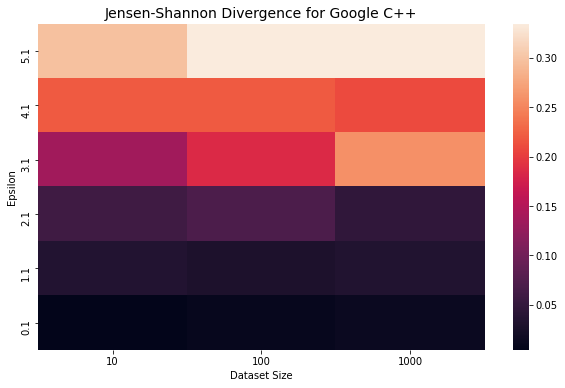

In [246]:
## Heatmap for JS divergence VS Epsilon and Dataset Size

z_hm = df_3d_js_go.copy()
z_hm = z_hm.pivot('eps', 'n', 'js')
z_hm = z_hm.sort_values(by='eps', ascending = False)

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(10)

ax = sns.heatmap(z_hm)

ax.set_xlabel("Dataset Size", )
ax.set_ylabel("Epsilon")
ax.set_title("Jensen-Shannon Divergence for Google C++", fontsize = 14)

plt.show()


We can also try animations for complex scenarios.


In [40]:
## Animation

fig = px.scatter(df_4d_js_go, x="n", y="aggr", animation_frame="eps", title="JS Divergence for Google C++",
           size="js", color = "aggr", log_x=True, size_max=55, range_x=[5,3000], range_y=[-1, 3])

fig.update_layout(transition = {'duration': 2000})

py.plot(fig, filename = 'Google C++ Animation', config={'scrollzoom': True}, auto_open=False)

fig.show()


## Efficiency Performance

At last, let's test the efficiency of these three libraries. We set up $\epsilon$ ranging from $0.1$ to $5.1$ increasing by $1.0$, the dataset size ranging from 10 to 1000 increasing by power of 10. Iteration to repeat the DP algorithms are set to be 500. And we test on `MEAN` here for all three libraries.


In [14]:
## Efficiency Performance for WhiteNoise-Core
start = datetime.now()

#Statements
for eps in epsilon:
    for n in dataset_size:
        for i in range(iters):
            element = dp_mean_wn(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")

running_time_wn = datetime.now() - start
print(running_time_wn)
        

0:01:09.817144


In [15]:
## Efficiency Performance for WhiteNoise-System
start = datetime.now()

#Statements
for eps in epsilon:
    for n in dataset_size:
        for i in range(iters):
            element = dp_mean_ws(eps, "/mnt/c/Users/mqdmj/Documents/GitHub/differential-privacy/test/PUMS_n" + str(n) + ".csv")

running_time_ws = datetime.now() - start
print(running_time_ws)

0:06:03.099128


In [ ]:
## Efficiency Performance for Google C++
## 123.57s(building and compiling, just for first time running) + 0.36s = 123.93s


# Conclusion

In all, let's summarise these three libraries briefly as below.

_WhiteNoise-Core_ tends to show least bias and highest accrucy paying the price of privacy.

_WhiteNoise-System_ tends to keep the privacy best but losing some unbiasness and accrucy.

_Google C++_ tends to balance privacy, bias and accrucy best.


# Existing Issues

1. The efficiency of _WhiteNoise-System_: Not fast enough comparing with _WhiteNoise-Core_ and _Google C++_. 

2. _WhiteNoise-System_ would return `inf` or `-inf` for at least `MEAN` query, which is what we used in this draft.

3. _WhiteNoise-Core_ and _WhiteNoise-System_ would return values out of the clamping range provided previously, which is not sensible. _Google C++_ doesn't have this issue when setting up bounding range.

4. For 3D plot, we are seeking more appropriate way to showcase the results to make them more straightforward and clear.